# Spitzer-ulens Tutorial Notebook
This notebook aims to demonstrate the usage of the the Spitzer-ulens package for observations with parallax.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import pickle
import emcee
import time as ti
from tqdm import tqdm
import os
from multiprocessing import Pool
import corner
from scipy import optimize as opt

from Spitzer_ulens import data_config
from Spitzer_ulens import models
from Spitzer_ulens import PLD

## Configuration and Preparation

This section demonstrates usage of the 'data_config' module.

In [2]:
coords = ('17:47:31.93','-24:31:21.6')
data_path = 'data/ob171140/rawdata/'

In [3]:
load_evt_from_file = True
if load_evt_from_file:
    fname = 'ob171140.pkl'
    with open(fname,'rb') as file:
        evt = pickle.load(file)
else:
    # Create a PLDEventData object from our data
    evt = data_config.PLDEventData(data_path,coords,recursive=True)
    # Save our PLDEventData object
    evt.save(filepath='ob171140.pkl',overwrite=True)

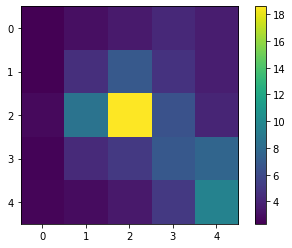

In [4]:
# Plotting an example of a 5-by-5 image
fig,ax = plt.subplots()
im = ax.imshow(evt.img[5][10])
fig.colorbar(im)
plt.show()

Text(0.5, 1.0, 'Spitzer Data')

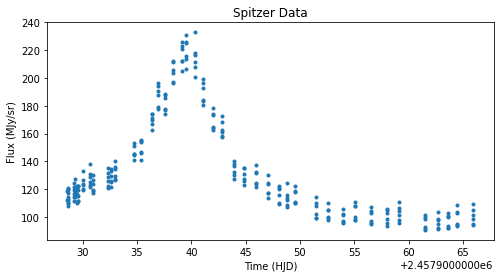

In [5]:
# Get raw photometry, error, and binned error
flux,flux_err,flux_frac,flux_scatter = evt.aperture_photometry()
time = np.array(evt.time)
ind = time<8000
time = (time[ind]+2450000).reshape(6,-1)
flux = flux[ind].reshape(6,-1)
flux_err = flux_err[ind].reshape(6,-1)
flux_frac = flux_frac[ind].reshape(6,-1,5,5)

# Plot our raw data
fig,ax = plt.subplots(figsize=(8,4))

ax.plot(time.ravel(),flux.ravel(),'C0.')
ax.set_xlabel('Time (HJD)')
ax.set_ylabel('Flux (MJy/sr)')
ax.set_title('Spitzer Data')

## Least-Squares Fit

In this section we do a least-squares fit to obtain some better parameter estimates. These will eventually become initial parameters for the MCMC fit. In this section we introduce the 'models' module.

In [6]:
# Make an initial guess for model parameters, which will be used as starting point for the least-squares fit. 
# I got these values from S. Calchi Novati et al 2018 AJ 155 261.

# Single lens model:
tE = 14.79             # Einstein radius crossing time
t0 = 2457940.7604      # Time of peak magnification
fs = 19.7              # Space-based source flux
fb = 82                # Space-based baseline flux

p0 = np.array([tE,t0,fb,fs])

# Specify some (loose) bounds on our parameters.
bounds = ([0,2457935,0,0],[140,2457945,np.inf,np.inf])

Text(0.5, 1.0, 'Spitzer Data Fit')

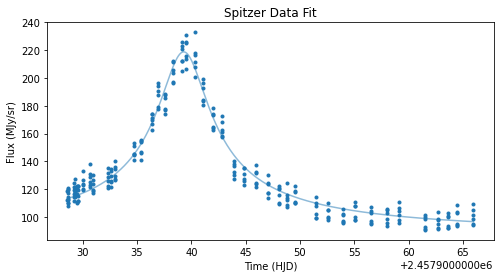

In [7]:
model = models.SingleLensModel()

popt_lsq,cov = opt.curve_fit(model,time.ravel(),flux.ravel(),p0,bounds=bounds)

timeplot = np.linspace(np.min(time),np.max(time),1000)

fig,ax = plt.subplots(figsize=(8,4))

ax.plot(timeplot,model(timeplot,*popt_lsq),'C0',alpha=0.5)
ax.plot(time.ravel(),flux.ravel(),'C0.')
ax.set_xlabel('Time (HJD)')
ax.set_ylabel('Flux (MJy/sr)')
ax.set_title('Spitzer Data Fit')

## Solving PLD Coefficients Analytically

In [8]:
# Solve for PLD coefficients analytically (X)
Y, Astro, Ps, A, C, E, X = PLD.analytic_solution(time,flux,flux_err,flux_frac,popt_lsq,model)
# Get detector model and divide it out to get new best-fit
fit,sys,corr,resi = PLD.get_bestfit(A, Ps, X, flux, Astro)

Text(0, 0.5, 'Residuals (MJy/sr)')

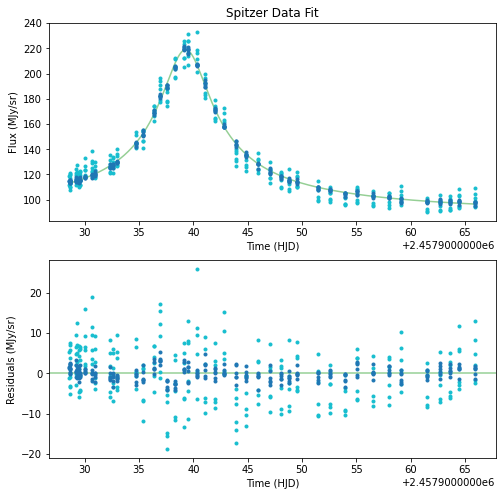

In [9]:
timeplot = np.linspace(np.min(time),np.max(time),1000)

fig,ax = plt.subplots(nrows=2,figsize=(8,8))

ax[0].plot(timeplot,model(timeplot,*popt_lsq),'C2',alpha=0.5)
ax[0].plot(time.ravel(),flux.ravel(),'C9.')
ax[0].plot(time.ravel(),corr.ravel(),'C0.')
ax[0].set_xlabel('Time (HJD)')
ax[0].set_ylabel('Flux (MJy/sr)')
ax[0].set_title('Spitzer Data Fit')

ax[1].axhline(c='C2',alpha=0.5)
ax[1].plot(time.ravel(),flux.ravel()-Astro.ravel(),'C9.')
ax[1].plot(time.ravel(),corr.ravel()-Astro.ravel(),'C0.')
ax[1].set_xlabel('Time (HJD)')
ax[1].set_ylabel('Residuals (MJy/sr)')

# MCMC Fit for PLD Parameters

In this section we run a Markov Chain Monte-Carlo (MCMC) fit to our data. This will explore parameter space to optimize the log-likelihood for our model to fit our data. We use the emcee package (https://github.com/dfm/emcee) to do our fit. The log-likelihood function we use is a method of the SingleLensParallaxModel class, as detailed in the 'Spitzer_ulens.models' module.

In [10]:
def run_mcmc(sampler,pos0,nsteps,visual=True,label=''):
    if visual:
        tic = ti.time()
        print('Running MCMC '+label+'...')
        
        # Using tqdm package to generate progress bars
        for pos, prob, state in tqdm(sampler.sample(pos0, iterations=nsteps),total=nsteps):
            pass

        print("Mean burn-in acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
        toc = ti.time()
        print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))
        return pos,prob,state
    else:
        pos,prob,state = sampler.run_mcmc(pos0,nsteps)
        return pos,prob,state

In [11]:
def get_MCMC_results(pos_chain,lnp_chain):
    _,_,npars = pos_chain.shape
    posit = pos_chain.reshape(-1,npars)

    # Get the percentile
    percs = np.percentile(posit, [16, 50, 84],axis=0)
    (MCMC_Results) = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*percs))))

    popt = MCMC_Results[:,0]
    std_hi = MCMC_Results[:,1]
    std_lo = MCMC_Results[:,2]

    # Get most probable params
    probs = lnp_chain.flatten()
    pmax = posit[np.argmax(probs)]
    
    return popt,pmax,std_hi,std_lo

In [12]:
load_chain_from_file = False
pos_chain_path = ''
lnp_chain_path = ''

if load_chain_from_file:
    pos_chain = np.load(path+'/samplerchain.npy')
    lnp_chain = np.load(path+'/samplerlnpro.npy')
else:
    p0 = popt_lsq
    nwalkers = 100
    nburnin = 300
    nprod = 1000
    
    # Generate the MCMC sampler with 100 walkers, our log-probability function, and our data. We
    # use pool from the multiprocessing package to parallelize the process.
    sampler = emcee.EnsembleSampler(nwalkers, len(p0), model.lnprob, a = 2, pool=Pool(),
                                    args=(bounds,time,flux,flux_err,flux_frac,
                                          flux_scatter))
    
    # Initialize the initial parameter positions for each walker by adding a random offset. Starting
    # our walkers in different positions allows us to explore more parameter space.
    pos0 = [p0*(1+1e-5*np.random.randn(sampler.ndim))+1e-5*np.abs(np.random.randn(sampler.ndim)) 
            for i in range(sampler.nwalkers)]
    
    # Run the first MCMC burn-in.
    pos1,prob,state = run_mcmc(sampler,pos0,nburnin,label='first burn-in')
    sampler.reset()

    #Run the MCMC from best spot from last time, and do another burn-in to get the walkers spread out.
    pos2 = pos1[np.argmax(prob)]
    
    # Slightly change position of walkers to prevent them from taking the same path
    pos2 = [pos2*(1+1e-6*np.random.randn(sampler.ndim))+1e-6*np.abs(np.random.randn(sampler.ndim)) 
            for i in range(sampler.nwalkers)]
    
    # Run the second burn-in
    pos2, prob, state = run_mcmc(sampler,pos2,nburnin,label='second burn-in')
    sampler.reset()
    
    #Run the final production run that will be saved
    pos_final, prob, state = run_mcmc(sampler,pos2,nprod,label='production')

    pos_chain = sampler.chain
    lnp_chain = sampler.lnprobability
    
# Get results from chain
popt_mcmc,pmax,std_hi,std_lo = get_MCMC_results(pos_chain,lnp_chain)

Running MCMC first burn-in...


  0%|                                                                  | 0/300 [00:00<?, ?it/s]/Users/Tarik/Library/Python/3.8/lib/python/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████| 300/300 [00:36<00:00,  8.11it/s]


Mean burn-in acceptance fraction: 0.414
MCMC runtime = 0.62 min

Running MCMC second burn-in...


100%|████████████████████████████████████████████████████████| 300/300 [00:45<00:00,  6.53it/s]


Mean burn-in acceptance fraction: 0.582
MCMC runtime = 0.77 min

Running MCMC production...


100%|██████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.45it/s]

Mean burn-in acceptance fraction: 0.594
MCMC runtime = 2.24 min



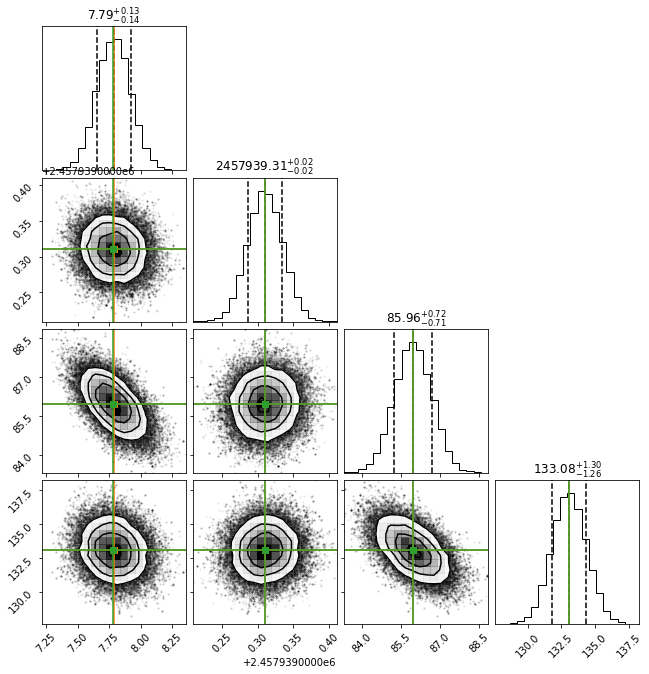

In [17]:
# Create corner plots to check for convergence
# 1d array of samples
samples = pos_chain.reshape((-1, len(popt_mcmc)))

# corner plot
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, plot_datapoints=True, 
                    title_kwargs={"fontsize": 12})

corner.overplot_lines(fig, popt_mcmc, color="C1", label='Mean parameter position')
corner.overplot_points(fig, popt_mcmc[None], marker="s", color="C1")
corner.overplot_lines(fig, pmax, color="C2", label='Most likely parameter position')
corner.overplot_points(fig, pmax[None], marker="s", color="C2")

#plt.legend(loc=(-5,7),fontsize=16)

In [14]:
# Re-run MCMC if it does not look converged. This cell can be run repeatedly.
rerun_mcmc = False
if rerun_mcmc:
    
    sampler = emcee.EnsembleSampler(nwalkers, len(p0), model.lnprob, a = 2, pool=Pool(),
                                    args=(bounds,time,time_g,flux,flux_err,flux_frac,
                                          flux_scatter,flux_g,flux_err_g))
    pos0 = pos_chain[-1]

    pos_final,prob_final,state_final = mcmc.run_mcmc(sampler,pos0,3000,label='production')

    pos_chain = sampler.chain
    lnp_chain = sampler.lnprobability
    
    popt_mcmc,pmax,std_hi,std_lo = get_MCMC_results(pos_chain,lnp_chain)

[7.78182955e+00 2.45793931e+06 8.59506803e+01 1.33099116e+02]


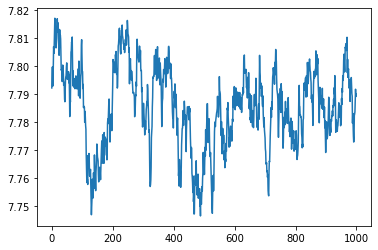

In [15]:
plt.plot(pos_chain.mean(axis=0)[:,0])
print(pmax)

In [ ]:
# Compute BIC
bic = mcmc.get_BIC(popt_mcmc, MODELFUNC, event.TIMES, PTOT, PTOT_E, E_BIN, PNORM, X)
print(bic)

In [ ]:
resi_corr = corr_mcmc-MODELFUNC(time,*popt_mcmc)
std = resi_corr.std()
indmax = np.argmax(np.abs(resi_corr))
timemax,resimax = time[indmax],resi_corr[indmax]

fig,ax = plt.subplots(figsize=(7,5))
ax.plot(time,resi_corr,'.',label='Residuals')
ax.plot(timemax,resimax,marker='s',fillstyle='none',color='red',markersize=10)
ax.text(timemax+0.7,resimax-0.3,'Peak fluctuation',fontsize=12)

ax.axhline(y=0,color='C1')
#ax.text(time[-1]+2.1,-0.1,r'best fit')
for i in range(1,5):
    ax.axhline(y=i*std,color='C1',ls='--',alpha=1-0.2*i)
    ax.axhline(y=-i*std,color='C1',ls='--',alpha=1-0.2*i)
    ax.text(time[-1]+2,i*std-0.1,r'$+%d\sigma$'%i)
    ax.text(time[-1]+2,-i*std-0.1,r'$-%d\sigma$'%i)
    
ax.set_ylabel('Residuals (MJy/sr)',fontsize=16)
ax.set_xlabel('Time (JD)',fontsize=16)

ax.legend(fontsize=12)

In [ ]:
pmin, pmax = 0, np.max(ptot)+5

# ylim for residuals
resi_std   = np.std(resi)
rmin, rmax = -4*resi_std, 4*resi_std

fig, axes = plt.subplots(nrows = 3, ncols = 1, sharex = True, figsize = (8, 9))

axes[0].plot(time, ptot, '.', label = 'Data')
axes[0].plot(time, fit, '.', label= 'Signal Fit', color='C1', alpha=0.5)
axes[0].set_ylabel('Photometry (MJy/str)', fontsize=13)
axes[0].set_ylim(pmin, pmax)
axes[0].legend()

axes[1].plot(time, corr, '.', label='Corrected Data', alpha=0.5)
axes[1].plot(timeplot, lcoptim, label='Astrophysical Model', color='C1', linewidth=3,alpha=0.5)
axes[1].set_ylabel('Photometry (MJy/str)', fontsize=13)
axes[1].set_ylim(pmin, pmax)
axes[1].legend()

axes[2].plot(time, resi, '.', label='Residuals', alpha=0.5)
axes[2].axhline(y=0, color='C1', linewidth=3,alpha=0.5)
axes[2].set_ylabel('Residuals (MJy/str)', fontsize=13)
axes[2].set_xlabel('Time (JD)', fontsize=13)
axes[2].set_ylim(rmin, rmax)
axes[2].legend()

axes[2].set_xlim(np.min(timeplot), np.max(timeplot))

fig.subplots_adjust(hspace = 0)